<a href="https://colab.research.google.com/github/varunSabnis/pytorch_course_udemy/blob/master/CIFAR_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision

In [0]:
import torch
from torchvision import datasets, transforms
from torch import nn
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
transform_train = transforms.Compose([transforms.Resize((32,32)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomAffine(0,shear=10, scale=(0.8, 1.2)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                                      ])

transform = transforms.Compose([transforms.Resize((32,32)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]) # mean and standard deviation of 0.5 for channel 1, here image has only one channel
training_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
validation_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [0]:
def image_convert(im_tensor):
  image = im_tensor.cpu().clone().detach().numpy() 
  image = image.transpose(1, 2, 0) # Change shape of image from 1*28*28 to 28*28*1
  image = image*(np.array((0.5, 0.5, 0.5))) + np.array((0.5, 0.5, 0.5)) 
  """
  y = (x - mean)/std
  x = y*std + mean  -- this will get back original image that was normalized
  """
  image = image.clip(0, 1) # Keep every pixel between 0 and 1
  return image

In [0]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

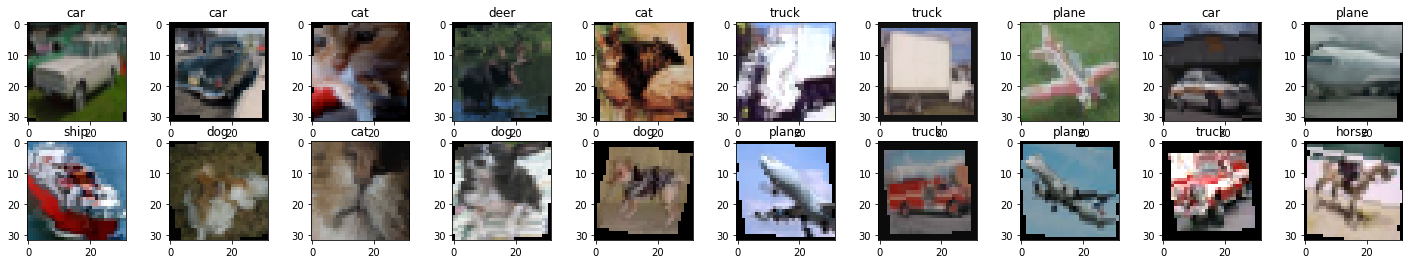

In [23]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))
for i in np.arange(20):
  ax = fig.add_subplot(2, 10, i+1)
  plt.imshow(image_convert(images[i]))
  ax.set_title(classes[labels[i].item()])


In [0]:
class LeNet(nn.Module):
  def compute_out_size(self, num_prev_layer_features, num_filters, kernel_size, stride=1, padding=0):
    import math
    pool_conv_out = math.ceil((((num_prev_layer_features + 2*padding - kernel_size)/stride + 1)/2))
    return(pool_conv_out, num_filters)

  def __init__(self, img_dim, filters, kernel_sizes, fc_layers, im_channels=1, pool_size=2, stride=1, padding=0):
    self.pool_size = pool_size
    super().__init__()
    self.conv1 = nn.Conv2d(im_channels, filters[0], kernel_sizes[0], stride=stride, padding=padding)
    conv1_out_size, _ = self.compute_out_size(img_dim, filters[0], kernel_sizes[0], stride=stride, padding=padding)
    self.conv2 = nn.Conv2d(filters[0], filters[1], kernel_sizes[1], stride=stride, padding=padding)
    conv2_out_size, _ = self.compute_out_size(conv1_out_size, filters[1], kernel_sizes[1], stride=stride, padding=padding)
    self.conv3 = nn.Conv2d(filters[1], filters[2], kernel_sizes[2], stride=stride, padding=padding)
    conv3_out_size, _ = self.compute_out_size(conv2_out_size, filters[2], kernel_sizes[2], stride=stride, padding=padding)
    print(conv3_out_size)
    self.fc_layer_input = conv3_out_size*conv3_out_size*filters[2]
    self.fc1 = nn.Linear(self.fc_layer_input, fc_layers[0])
    self.dropout1 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(fc_layers[0], fc_layers[1])

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, self.pool_size, self.pool_size)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, self.pool_size, self.pool_size)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x, self.pool_size, self.pool_size)
    x = x.view(-1, self.fc_layer_input)
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = self.fc2(x)
    return x

In [0]:
def get_image_shape(images):
  image = image_convert(images[0])
  return image.shape[0], image.shape[1]

In [9]:
im_shape_x, im_shape_y = get_image_shape(images)
# For nxn type images and kernels  
model = LeNet(im_shape_x, im_channels=3, filters=[16, 32, 64], kernel_sizes=[3,3,3], fc_layers=[500,10], padding=1).to(device) 
model 

4


LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [11]:
epochs = 15
running_loss_history = []
running_correct_history = []
val_running_loss_history = []
val_running_correct_history = []

print("len of training loader {}".format(len(training_loader)))
print("len of validation loader {}".format(len(validation_loader)))
for e in range(epochs):
  running_loss = 0.0
  running_corrects = 0.0
  validation_running_loss = 0.0
  validation_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs, 1)
    running_corrects += torch.sum(preds == labels.data)
    running_loss += loss.item()
  with torch.no_grad():
    for val_inputs, val_labels in validation_loader:
      val_inputs = val_inputs.to(device)
      val_labels = val_labels.to(device)
      val_outputs = model(val_inputs)
      val_loss = criterion(val_outputs, val_labels)
      _, val_preds = torch.max(val_outputs, 1)
      validation_running_corrects += torch.sum(val_preds == val_labels.data)
      validation_running_loss += val_loss.item()

  epoch_loss = running_loss/(len(training_loader))
  acc = running_corrects/(len(training_loader))
  val_epoch_loss = validation_running_loss/(len(validation_loader))
  val_acc = validation_running_corrects/(len(validation_loader))

  val_running_loss_history.append(val_epoch_loss)
  running_loss_history.append(epoch_loss)
  running_correct_history.append(acc)
  val_running_correct_history.append(val_acc)

  print("training loss : {:.4f} training accuracy : {:.2f}".format(epoch_loss, acc))
  print("Validation loss : {:.4f} Validation accuracy : {:.2f}".format(val_epoch_loss, val_acc))

len of training loader 500
len of validation loader 100
training loss : 1.6839 training accuracy : 38.13
Validation loss : 1.3916 Validation accuracy : 49.01
training loss : 1.3817 training accuracy : 50.09
Validation loss : 1.2060 Validation accuracy : 56.47
training loss : 1.2479 training accuracy : 55.21
Validation loss : 1.1726 Validation accuracy : 58.59
training loss : 1.1579 training accuracy : 58.83
Validation loss : 1.0267 Validation accuracy : 63.90
training loss : 1.0866 training accuracy : 61.41
Validation loss : 0.9926 Validation accuracy : 64.97
training loss : 1.0374 training accuracy : 63.24
Validation loss : 0.9426 Validation accuracy : 67.14
training loss : 0.9994 training accuracy : 64.80
Validation loss : 0.9274 Validation accuracy : 67.70
training loss : 0.9690 training accuracy : 65.91
Validation loss : 0.8797 Validation accuracy : 69.18
training loss : 0.9304 training accuracy : 67.55
Validation loss : 0.8761 Validation accuracy : 68.96
training loss : 0.9157 tra

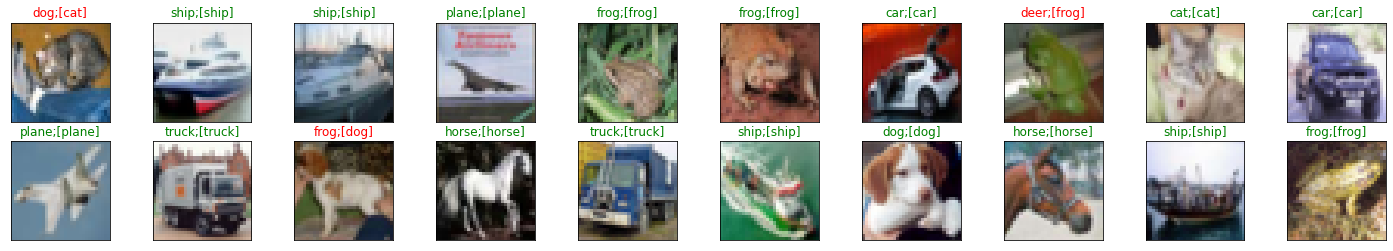

In [26]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(image_convert(images[idx]))
  ax.set_title("{};[{}]".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx].item() == labels[idx].item() else "red"))

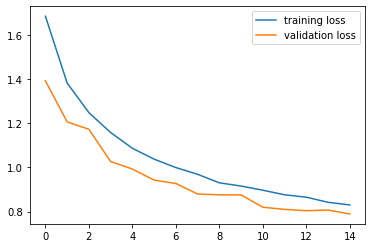

In [13]:
plt.plot(running_loss_history, label="training loss")
plt.plot(val_running_loss_history, label="validation loss")
plt.legend()

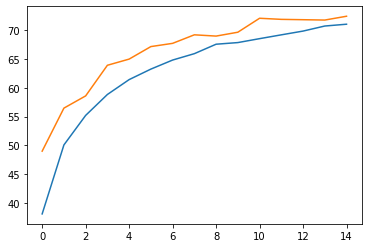

In [14]:
plt.plot(running_correct_history, label="training accuracy")
plt.plot(val_running_correct_history, label="validation accuracy")

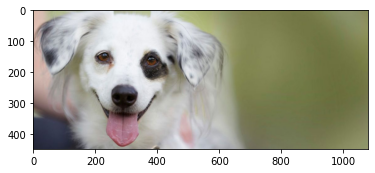

In [15]:
import PIL.ImageOps
import requests
from PIL import Image
url = 'https://d17fnq9dkz9hgj.cloudfront.net/breed-uploads/2018/09/dog-landing-hero-lg.jpg?bust=1536935129&width=1080'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

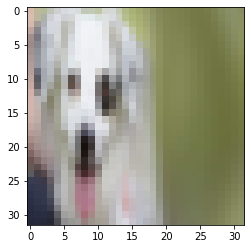

In [16]:
img = transform(img)
plt.imshow(image_convert(img))

In [24]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

dog
